# Load data from MOST .nc file

Sample of how to load data from a MOST simulation of Seaside, OR.

Then extract and plot:
 - time series at specified gauge locations, 
 - inundation maps at specified times

In [1]:
%matplotlib inline

In [2]:
from pylab import *
import netCDF4, xarray
from clawpack.visclaw import geoplot, colormaps
from scipy.interpolate import RegularGridInterpolator

In [3]:
ncfile = '/Users/rjl/D/seaside_tsunami_data.nc'

In [4]:
ncdata = xarray.open_dataset(ncfile, decode_timedelta=False)
#ncdata = netCDF4.Dataset(ncfile, 'r')  # alternative way, but xarray gives nicer wrapper

In [5]:
ncdata

<xarray.Dataset> Size: 9GB
Dimensions:  (time: 241, x: 757, y: 973)
Coordinates:
  * time     (time) float64 2kB 0.0 15.0 30.0 ... 3.57e+03 3.585e+03 3.6e+03
    lon      (x) float64 6kB ...
    lat      (y) float64 8kB ...
Dimensions without coordinates: x, y
Data variables:
    bathy    (y, x) float64 6MB ...
    h        (time, y, x) float64 1GB ...
    depth    (time, y, x) float64 1GB ...
    u        (time, y, x) float64 1GB ...
    v        (time, y, x) float64 1GB ...
    speed    (time, y, x) float64 1GB ...
    momFlux  (time, y, x) float64 1GB ...
Attributes:
    title:        Tsunami Model Output for Seaside, Oregon
    description:  Water surface elevation, inundation depth, velocities, and ...
    history:      Created on 12-May-2025 14:15:27
    author:       Yong Wei, U. of Washington & NOAA Pacific Marine Environmen...

In [6]:
ncdata.variables.keys()

KeysView(Frozen({'time': <xarray.IndexVariable 'time' (time: 241)> Size: 2kB
array([   0.,   15.,   30., ..., 3570., 3585., 3600.], shape=(241,))
Attributes:
    units:      seconds
    long_name:  Time, 'lon': <xarray.Variable (x: 757)> Size: 6kB
[757 values with dtype=float64]
Attributes:
    units:          degrees_east
    standard_name:  lon
    long_name:      Longitude
    axis:           X, 'lat': <xarray.Variable (y: 973)> Size: 8kB
[973 values with dtype=float64]
Attributes:
    units:          degrees_north
    standard_name:  lat
    long_name:      Latitude
    axis:           Y, 'bathy': <xarray.Variable (y: 973, x: 757)> Size: 6MB
[736561 values with dtype=float64]
Attributes:
    units:      meters
    long_name:  Bathymetry referring to Mean High Water, 'h': <xarray.Variable (time: 241, y: 973, x: 757)> Size: 1GB
[177511201 values with dtype=float64]
Attributes:
    units:      meters
    long_name:  Water Surface Elevation, 'depth': <xarray.Variable (time: 241, y: 973

## extract as numpy arrays and transpose so [i,j] index corresponds to [x,y]:

In [7]:
t = asarray(ncdata.variables['time'])
x = asarray(ncdata.variables['lon'])
y = asarray(ncdata.variables['lat'])

# reorganize multidimensional arrays so [i,j,k] index corresponds to (x,y,t),
# and then convert to numpy arrays:
B = asarray(ncdata.variables['bathy'].transpose('x','y'))
h = asarray(ncdata.variables['h'].transpose('x','y','time'))
depth = asarray(ncdata.variables['depth'].transpose('x','y','time'))
speed = asarray(ncdata.variables['speed'].transpose('x','y','time'))

X,Y = meshgrid(x,y,indexing='ij')
tmin = t / 60. # convert to minutes

In [8]:
print('t has %i times with increment %.2f seconds' % (len(t),(t[1]-t[0])))
print('Spatial arrays on grid with %i longitudes, %i latitudes' % (len(x),len(y)))
print('Shapes: ', t.shape, x.shape, y.shape, B.shape, h.shape)

t has 241 times with increment 15.00 seconds
Spatial arrays on grid with 757 longitudes, 973 latitudes
Shapes:  (241,) (757,) (973,) (757, 973) (757, 973, 241)


In [9]:
ncdata.close()

## make interpolators for evaluating at arbitray x,y,t:

In [10]:
h_fcn = RegularGridInterpolator((x,y,t), h)
depth_fcn = RegularGridInterpolator((x,y,t), depth)
speed_fcn = RegularGridInterpolator((x,y,t), speed)
B_fcn = RegularGridInterpolator((x,y), B)

## Plotting stuff:

In [11]:
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})
sea_cmap = plt.get_cmap('Blues_r')

cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap),
                                     data_limits=[-1,1],
                                     data_break=0)

In [12]:
def plot_topo():
    fig,ax = subplots(figsize=(6,8))
    pcolormesh(X,Y,B,cmap=cmap)
    clim(-30,30)
    colorbar(extend='both',shrink=0.8,label='meters')
    ax.set_aspect(1/cos(pi*y.mean()/180))
    ticklabel_format(useOffset=False)
    xticks(rotation=20)
    title('Bathymetry / topography relative to MHW')

def plot_topo_contours(clines=[0.]):
    fig,ax = subplots(figsize=(6,8))
    contour(X,Y,B,clines,colors='g',linewidths=0.8)
    ax.set_aspect(1/cos(pi*y.mean()/180))
    ticklabel_format(useOffset=False)
    xticks(rotation=20)
    #title('Bathymetry / topography relative to MHW')

## Code to extract a time series at a point:

In [13]:
def extract_gauge(xg, yg, make_plots=True):
    """
    Extract times series at a gauge location xg,yg
    """

    h_series = h_fcn((xg,yg,t))
    depth_series = depth_fcn((xg,yg,t))
    speed_series = speed_fcn((xg,yg,t))
    Bg = B_fcn((xg,yg))

    if make_plots: 
    
        plot_topo()
        plot([xg], [yg], 'rx')
        text(xg+0.001, yg, 'Gauge', ha='left', color='r')
        
        figure(figsize=(8,6))
        subplot(211)
        plot(tmin, h_series, 'b', label='surface elevation')
        plot(tmin, depth_series, 'r', label='depth')
        legend(loc='upper left', framealpha=1)
        grid(True)
        xlabel('minutes')
        ylabel('meters')
        title('B = %.2fm at x = %.4f, y = %.4f' % (Bg,xg,yg));
    
        subplot(212)
        plot(tmin, speed_series, 'm', label='speed')
        grid(True)
        legend(loc='upper left', framealpha=1)
        xlabel('minutes')
        ylabel('meters / second')
        tight_layout()

    return t, h_series, depth_series, speed_series

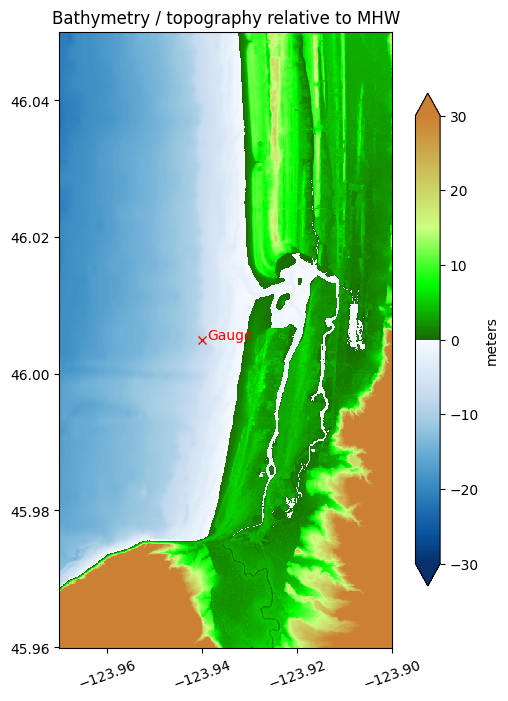

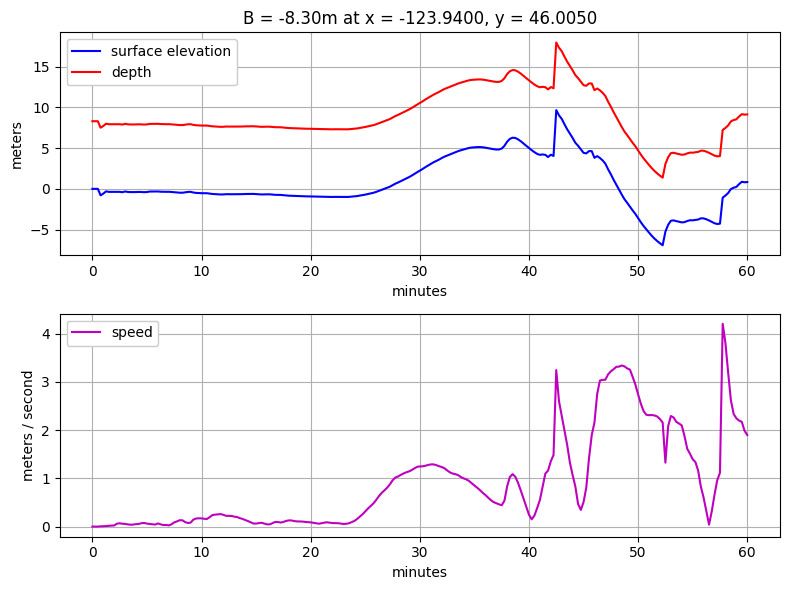

In [14]:
t, h_series, depth_series, speed_series = extract_gauge(-123.94, 46.005)

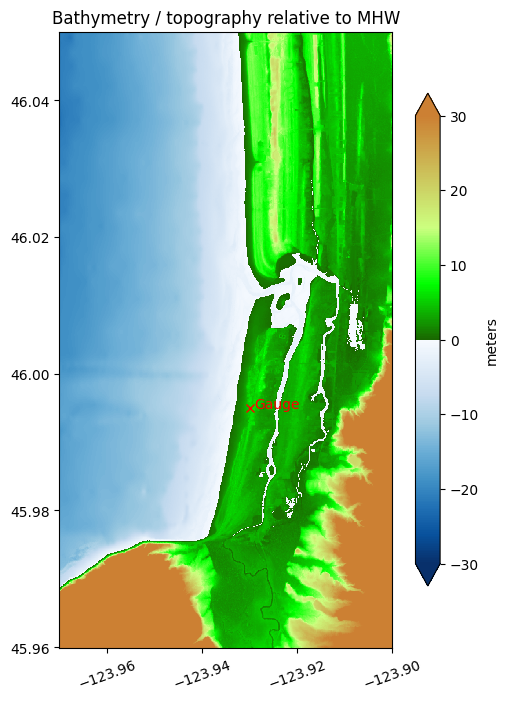

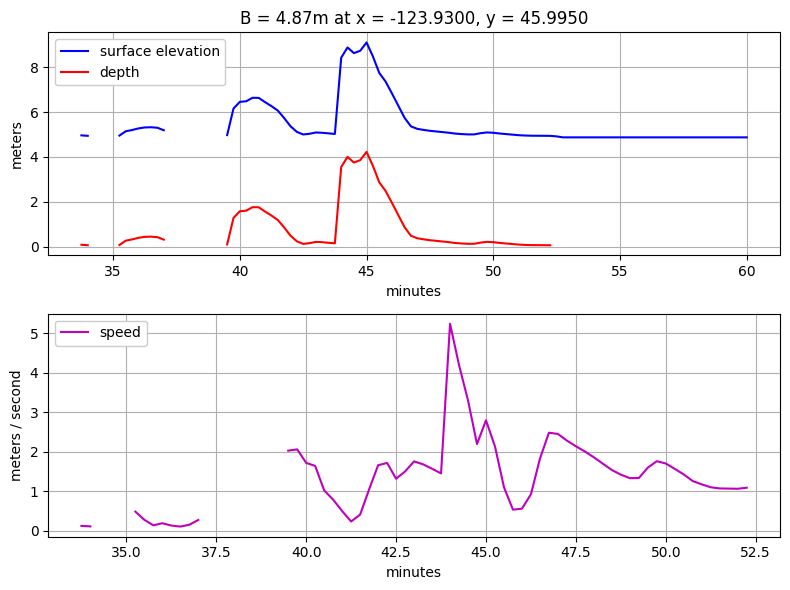

In [15]:
t, h_series, depth_series, speed_series = extract_gauge(-123.93, 45.995)

## Code to extract a snapshot of depth at a give time:

In [16]:
def extract_grid_onshore(tt, make_plots=True):
    """
    extract depth and speed at time tt (minutes) at onshore points (nan offshore)
    if make_plots:  also plot depth on contour plot of topo
    """
    depth_t = depth_fcn((X,Y,tt*60))
    depth_t = where(isnan(depth_t), 0., depth_t)  # replace nan by 0 depth
    depth_onshore = where(B>0, depth_t, nan)      # replace depth by nan offshore
    
    speed_t = where(isnan(speed_t), 0., speed_t)
    speed_t = speed_fcn((X,Y,tt*60))
    speed_onshore = where(B>0, speed_t, nan)
    
    if make_plots:
        
        #cmap_reds = plt.get_cmap('Reds')
        cmap = plt.get_cmap('YlOrRd')
        cmap.set_under([.1,.7,.1])
        cmap.set_over('m')
        plot_topo_contours()
        pcolormesh(X,Y,depth_onshore,cmap=cmap)
        clim(0.05,6)
        colorbar(extend='max',label='meters',shrink=0.8)
        axis([-123.96, -123.9025, 45.972, 46.0275])
        title('Onshore depth at t = %.2f minutes' % tt)

    return depth_onshore, speed_onshore

In [17]:
depth_onshore, speed_onshore = extract_grid_onshore(35)

UnboundLocalError: cannot access local variable 'speed_t' where it is not associated with a value

In [ ]:
depth_onshore, speed_onshore = extract_grid_onshore(45)

## Create a smaller .nc file with only the surface elevation:

Illustrates how to write netcdf files using xarray.

In [ ]:
data_dict = {'eta': (('x','y','t'), h)}
coords = {'x':x, 'y':y, 't':t}
ds = xarray.Dataset(data_dict, coords)

In [ ]:
ds.to_netcdf('test_eta.nc')

In [ ]:
!du -hs test_eta.nc

### reload to test:

In [ ]:
ff = xarray.open_dataset('test_eta.nc')

In [ ]:
ff

In [ ]:
asarray(ff.variables['eta']).shape

In [ ]:
ff.close()

In [ ]:
RegularGridInterpolator?